# Obtain Uniprot IDs for all human kinases

The definition of _kinase_ is not as straightforward as one could think. Throughout the literature you can find several manuscripts that list an authoritative list of kinases to query in an assay or include in domain-specific database. Surprisingly, the criteria used to nominate how a kinase makes it to the list or not is not consistent or obvious, and this results into slightly divergent definitions of what the human kinome really represents. In this notebook we aim to discuss these discrepancies and figure out a way to consistently agree on a definition for our future kinase-centric studies.

> To that avail, we will query online databases, web services and documents using `urllib`, `requests`, `beautifulsoup4` and `pandas`.

In [1]:
# Some imports and helper globals
import io
import urllib.request
from pathlib import Path

import requests
import bs4
import pandas as pd
from matplotlib import pyplot as plt

REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / "data"

SOURCES = {}

## Enumerate all possible sources for human kinases

There are several nomenclatures commonly used to refer to kinases: xName, Manning, HGNC... While there are some overlaps, there's no uniquely identifying naming system, so instead we will use Uniprot's identifiers as our primary keys. These can be mapped to other identifiers whenever available.

There are several sources that can be used to identify the human kinome in Uniprot:

* __A)__ [KinHub](http://kinhub.org/kinases.html) (based on Eid, 2017)
* __B)__ [KLIFS](https://klifs.vu-compmedchem.nl/) (based on Kooistra, 2015 and Linden 2013)
* __C)__ [Pkinfam](https://www.uniprot.org/docs/pkinfam.txt) - Uniprot's _Human and mouse protein kinases: classification and index_.
* __D1)__ Dunbrack's structurally validated kinase alignment  (based on Dunbrack, 2019)
* __D2)__ Dunbrack's `kincore` webserver (based on Dunbrack, 2019)
* __E)__  Kinbase (based on Manning, 2002)
* __F)__ Handcrafted UniProt query

Other possible resources we have not checked yet:

* Kanev, 2019 "The Landscape of Atypical and Eukaryotic Protein Kinases"
* Barton, 2007 "Classification and functional annotation of eukaryotic protein kinases" -- maybe uninformative
* Hunter, 2000 "Signaling-2000 and Beyond" -- maybe uninformative

These online references might help shed light on this issue:

* https://www.biostars.org/p/131138/
* https://github.com/macarthur-lab/gene_lists

### A) KinHub

[Kinhub.org](http://kinhub.org/kinases.html) maintains a HTML table in its webpage that can be retrieved with `requests` and `beautifulsoup`.

> __Citation__:
> Eid S., Turk S., Volkamer A., Rippmann F., and Fulle S. (2017)
> KinMap: a web-based tool for interactive navigation through human kinome data. BMC Bioinformatics, 18:16. [DOI: 10.1186/s12859-016-1433-7 ](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1433-7)

In [2]:
r = requests.get("http://kinhub.org/kinases.html")
r.raise_for_status()
html = bs4.BeautifulSoup(r.text)

In [3]:
table = html.find("table")
columns = [cell.text.strip() for cell in table.find("thead").find_all("th")]
records = [
    [cell.text.strip() for cell in row.find_all("td")]
    for row in table.find("tbody").find_all("tr")
]
kinhub = SOURCES["kinhub"] = pd.DataFrame.from_records(records, columns=columns).sort_values(
    by="xName"
)
kinhub

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
336,AAK1,AAK1,AAK1,AP2-associated protein kinase 1,Other,NAK,,Q2M2I8
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
24,ABL2,ARG,ABL2,Abelson tyrosine-protein kinase 2,TK,Abl,,P42684
529,ABR,ABR,ABR,Active breakpoint cluster region-related protein,Atypical,BCR,,Q12979
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
...,...,...,...,...,...,...,...,...
274,p38g,p38g,MAPK12,Mitogen-activated protein kinase 12,CMGC,MAPK,p38,P53778
209,p70S6K,p70S6K,RPS6KB1,Ribosomal protein S6 kinase beta-1,AGC,RSK,RSKp70,P23443
210,p70S6Kb,p70S6Kb,RPS6KB2,Ribosomal protein S6 kinase beta-2,AGC,RSK,RSKp70,Q9UBS0
477,skMLCK,skMLCK,MYLK2,Myosin light chain kinase 2,CAMK,MLCK,,Q9H1R3


### B) KLIFS

[KLIFS](https://klifs.vu-compmedchem.nl/) maintains their own internal list of kinase names as part of their database. This can be retrieved via their JSON API as follows. It requires two steps: 1) getting the list of names, 2) getting the metadata associated to each name. All of this is then dumped into a dataframe.

> __Citations__
> 
> Oscar P. J. van Linden, Albert J. Kooistra, Rob Leurs, Iwan J. P. de Esch, and Chris de Graaf* (2013). KLIFS: A Knowledge-Based Structural Database To Navigate Kinase–Ligand Interaction Space. J. Med. Chem. 2014, 57, 2, 249–277. [DOI: 10.1021/jm400378w](https://doi.org/10.1021/jm400378w)
> 
> Albert J. Kooistra, Georgi K. Kanev, Oscar P.J. van Linden, Rob Leurs, Iwan J.P. de Esch, Chris de Graaf (2015). KLIFS: a structural kinase-ligand interaction database. Nucleic Acids Research, Volume 44, Issue D1, 4 January 2016, Pages D365–D371. [DOI: 10.1093/nar/gkv1082](https://doi.org/10.1093/nar/gkv1082)
>
> Georgi K. Kanev, Chris de Graaf, Iwan J.P. de Esch, Rob Leurs, Thomas Würdinger, Bart A. Westerman, Albert J.Kooistra (2019). The Landscape of Atypical and Eukaryotic Protein Kinases. Trends in Pharmacological Sciences, Volume 40, Issue 11, November 2019, Pages 818-832. [DOI: 10.1016/j.tips.2019.09.002](https://doi.org/10.1016/j.tips.2019.09.002)

In [4]:
r = requests.get("https://klifs.net/api/kinase_names?species=HUMAN")
r.raise_for_status()
data = r.json()
all_ids = [record["kinase_ID"] for record in data]

In [5]:
r = requests.get(
    f"https://klifs.net/api/kinase_information?kinase_ID={','.join(map(str, all_ids))}"
)
r.raise_for_status()
data = r.json()

In [6]:
items = []
for record in data:
    items.append(
        {
            "KLIFS Name": record["name"],
            "HGNC Name": record["HGNC"],
            "Family": record["family"],
            "Group": record["group"],
            "Class": record["kinase_class"],
            "Kinase Name": record["full_name"],
            "UniprotID": record["uniprot"],
            "IUPHAR": record["iuphar"],
            "Pocket": record["pocket"],
            "KLIFS ID": record["kinase_ID"],
        }
    )
klifs = SOURCES["KLIFS"] = pd.DataFrame.from_dict(items).sort_values(by="KLIFS Name")
klifs

,KLIFS Name,HGNC Name,Family,Group,Class,Kinase Name,UniprotID,IUPHAR,Pocket,KLIFS ID
276,AAK1,AAK1,NAK,Other,BIKE,AP2 associated kinase 1,Q2M2I8,1921,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,277
391,ABL1,ABL1,Abl,TK,,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,1923,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,392
392,ABL2,ABL2,Abl,TK,,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1924,HKLGGGQYGEVYVVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIVTE...,393
393,ACK,TNK2,Ack,TK,,"tyrosine kinase, non-receptor, 2",Q07912,2246,EKLGDGSFGVVRRVAVKCLDFIREVNAMHSLDRNLIRLYGVKMVTE...,394
522,ACTR2,ACVR2A,STKR,TKL,Type2,activin A receptor type IIA,P27037,1791,EVKARGRFGCVWKVAVKIFSWQNEYEVYSLPGENILQFIGAWLITA...,523
...,...,...,...,...,...,...,...,...,...,...
251,p38g,MAPK12,MAPK,CMGC,p38,mitogen-activated protein kinase 12,P53778,1501,QPVGSGAYGAVCSVAIKKLRAYRELRLLKHMRENVIGLLDVYLVMP...,252
50,p70S6K,RPS6KB1,RSK,AGC,p70,ribosomal protein S6 kinase B1,P23443,1525,RVLGKGGYGKVFQFAMKVLHTKAERNILEEVKPFIVDLIYAYLILE...,51
51,p70S6Kb,RPS6KB2,RSK,AGC,p70,ribosomal protein S6 kinase B2,Q9UBS0,1526,RVLGKGGYGKVFQYAMKVLHTRAERNILESVKPFIVELAYAYLILE...,52
154,skMLCK,MYLK2,MLCK,CAMK,,myosin light chain kinase 2,Q9H1R3,1553,EALGGGKFGAVCTLAAKVIMVLLEIEVMNQLNRNLIQLYAAVLFME...,155


In [7]:
klifs.Group.unique()

array(['Other', 'TK', 'TKL', 'Atypical', 'AGC', 'CAMK', 'RGC', 'CMGC',
       'CK1', 'STE'], dtype=object)

### C) Pkinfam

UniProt maintains [a txt file](https://www.uniprot.org/docs/pkinfam.txt) with a kinase index: `pkinfam`. We can try to parse it and see what information we have there.

> References:
> 
> >
> Hunter T.
> Signaling -- 2000 and beyond.
> Cell 100:113-127(2000).
>
> Manning G., Whyte D.B., Martinez R., Hunter T., Sudarsanam S.
> The protein kinase complement of the human genome.
> Science 298:1912-1934(2002).
>
> Miranda-Saavedra D., Barton G.J.
> "Classification and functional annotation of eukaryotic protein
> kinases.
> Proteins 68:893-914(2007).

In [8]:
r = requests.get("https://www.uniprot.org/docs/pkinfam.txt")
r.raise_for_status()
text = r.text

In [9]:
items = []
current_category = None
lines = iter(text.splitlines())
for line in lines:
    if line.startswith("==="):  # this is a header
        line = next(lines)
        current_category = line.strip()
        next(lines)
        next(lines)
        continue
    if not line.strip() or not current_category or "_HUMAN" not in line:
        continue
    if line.startswith("---") and current_category:
        break

    fields = line.split()
    name = fields[0]
    uniprot_id = fields[2].replace("(", "").replace(")", "")
    items.append(
        {
            "Name": name,
            "Family": current_category,
            "UniprotID": uniprot_id,
        }
    )
pkinfam = SOURCES["pkinfam"] = pd.DataFrame.from_dict(items).sort_values(by="Name")
pkinfam

,Name,Family,UniprotID
403,AAK1,Other,Q2M2I8
313,AATK,Tyr protein kinase family,Q6ZMQ8
314,ABL1,Tyr protein kinase family,P00519
315,ABL2,Tyr protein kinase family,P42684
279,ACVR1,TKL Ser/Thr protein kinase family,Q04771
...,...,...,...
481,WNK2,Other,Q9Y3S1
482,WNK3,Other,Q9BYP7
483,WNK4,Other,Q96J92
401,YES1,Tyr protein kinase family,P07947


In [10]:
pkinfam.Family.unique()

array(['Other', 'Tyr protein kinase family',
       'TKL Ser/Thr protein kinase family',
       'Atypical: ADCK protein kinase family',
       'AGC Ser/Thr protein kinase family',
       'Atypical: Alpha-type protein kinase family',
       'Atypical: PI3/PI4-kinase family',
       'Atypical: PDK/BCKDK protein kinase family',
       'CAMK Ser/Thr protein kinase family',
       'CMGC Ser/Thr protein kinase family',
       'CK1 Ser/Thr protein kinase family',
       'Atypical: FAST protein kinase family',
       'RGC kinase: adenylyl cyclase class-4/guanylyl cyclase',
       'STE Ser/Thr protein kinase family',
       'NEK Ser/Thr protein kinase family',
       'Atypical: RIO-type Ser/Thr kinase family'], dtype=object)

### D1) Dunbrack's structurally validated kinase alignment

Dataset extracted from:

> Modi, V., Dunbrack, R.L. A Structurally-Validated Multiple Sequence Alignment of 497 Human Protein Kinase Domains. Sci Rep 9, 19790 (2019). https://doi.org/10.1038/s41598-019-56499-4

In [11]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-56499-4/MediaObjects/41598_2019_56499_MOESM4_ESM.txt"
dunbrack_msa = SOURCES["dunbrack_msa"] = pd.read_csv(url, sep=r"\s+").rename(
    columns={"5_Uni_acc": "UniprotID"}
)
dunbrack_msa

,1_Group,2_Gene,3_HGNC,4_Uni_entry,UniprotID,6_Domain_begin,7_Domain_end,8_Domain_length,9_Largest_insert_length,10_PDB_validation,11_Conformational_state,12_Dihedral_state,13_Group_in_Uni,14_Group_in_Manning,15_Synonymn
0,AGC,AKT1,HGNC:391,AKT1_HUMAN,P31749,150,408,259,9,6NPZB,DFGin,BLAminus,AGC,AGC,"PKB,RAC"
1,AGC,AKT2,HGNC:392,AKT2_HUMAN,P31751,152,409,258,9,3E8DB,DFGin,BLAminus,AGC,AGC,NaN
2,AGC,AKT3,HGNC:393,AKT3_HUMAN,Q9Y243,148,405,258,9,NaN,NaN,NaN,AGC,AGC,PKBG
3,AGC,CDC42BPA,HGNC:1737,MRCKA_HUMAN,Q5VT25,77,343,267,14,NaN,NaN,NaN,AGC,AGC,KIAA0451
4,AGC,CDC42BPB,HGNC:1738,MRCKB_HUMAN,Q9Y5S2,76,342,267,14,5OTFA,DFGin,BLAminus,AGC,AGC,KIAA1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,TYR,TYK2_1,HGNC:12440,TYK2_HUMAN,P29597,589,868,280,26,3ZONA,DFGin,NaN,TYR,TYR,NaN
493,TYR,TYK2_2,HGNC:12440,TYK2_HUMAN,P29597,897,1171,275,21,4GVJA,DFGin,BLAminus,TYR,TYR,NaN
494,TYR,TYRO3,HGNC:12446,TYRO3_HUMAN,Q06418,518,788,271,10,NaN,NaN,NaN,TYR,TYR,"BYK,DTK,RSE,SKY,TIF"
495,TYR,YES1,HGNC:12841,YES_HUMAN,P07947,277,528,252,10,NaN,NaN,NaN,TYR,TYR,YES


### D2) Dunbrack's `kincore` webserver

The [Kinase Conformation Resource](http://dunbrack3.fccc.edu/kincore/) (`kincore`) is the accompanying website for 2019's kinase-focused works by Modi and Dunbrack:

> Defining a new nomenclature for the structures of active and inactive kinases. Vivek Modi and Roland L. Dunbrack, PNAS 2019, 116(14) 6818-6827.
> Structurally-Validated Multiple Sequence Alignment of 497 Human Protein Kinase Domains. Vivek Modi and Roland L. Dunbrack, Sci Rep 2019, 9, 19790.

All kinases thereby listed are programmably accessible via a TSV file in this url:

```
http://dunbrack3.fccc.edu/kincore/static/downloads/text-files/Human_Allgroups_Allspatials_Alldihedrals_All.tab
```

In [12]:
url = "http://dunbrack3.fccc.edu/kincore/static/downloads/text-files/Human_Allgroups_Allspatials_Alldihedrals_All.tab"
dunbrack_kincore = SOURCES["dunbrack_kincore"] = pd.read_csv(url, sep="\t")
dunbrack_kincore

,Organism,Group,Gene,UniprotID,PDB,Method,Resolution,Rfac,FreeRfac,DomainBoundary,...,Ligand,LigandType,DFG_Phe,Edia_X_O,Edia_Asp_O,Edia_Phe_O,Edia_Gly_O,Phosphorylation,Mutations,ProteinName
0,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6NPZB,XRAY,2.12,0.19,0.24,150-408,...,No_ligand,No_ligand,293,0.85,0.88,0.94,0.91,T308 S473 S477,None,RAC-alpha serine/threonine-protein kinase
1,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6NPZA,XRAY,2.12,0.19,0.24,150-408,...,No_ligand,No_ligand,293,0.88,0.92,0.93,1.04,T308 S473 S477,None,RAC-alpha serine/threonine-protein kinase
2,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6BUUB,XRAY,2.40,0.18,0.23,150-408,...,No_ligand,No_ligand,293,0.92,0.78,0.99,0.86,T308 S473 S477,None,RAC-alpha serine/threonine-protein kinase
3,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6BUUA,XRAY,2.40,0.18,0.23,150-408,...,No_ligand,No_ligand,293,0.92,0.81,1.00,0.87,T308 S473 S477,None,RAC-alpha serine/threonine-protein kinase
4,Homo sapiens,AGC,AKT1,AKT1_HUMAN,4EKLA,XRAY,2.00,0.17,0.23,150-408,...,0RF:501,Type1,293,1.05,1.05,1.00,1.04,T308,S473D,RAC-alpha serine/threonine-protein kinase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8208,Homo sapiens,TYR,TYK2_1,TYK2_HUMAN,3ZONA,XRAY,2.15,0.22,0.27,589-868,...,IK1:1871,Type1,760,0.97,0.99,0.96,0.95,None,None,Non-receptor tyrosine-protein kinase TYK2
8209,Homo sapiens,TYR,TYK2_1,TYK2_HUMAN,4OLIA,XRAY,2.80,0.20,0.26,589-868,...,2TT:1201 2TT:1202,Type1 Allosteric,760,0.91,0.86,0.67,0.63,None,D1023N,Non-receptor tyrosine-protein kinase TYK2
8210,Homo sapiens,TYR,ZAP70,ZAP70_HUMAN,1U59A,XRAY,2.30,0.22,0.27,337-595,...,STU:100,Type1,480,0.85,0.87,1.00,0.81,None,None,Tyrosine-protein kinase ZAP-70
8211,Homo sapiens,TYR,ZAP70,ZAP70_HUMAN,4K2RA,XRAY,3.00,0.21,0.29,337-595,...,ANP:702,Type1,480,0.72,0.62,0.44,0.59,None,D461N,Tyrosine-protein kinase ZAP-70


Unfortunately, this database only contains kinases for which structural data is available, so the number of unique UniprotIDs is considerably smaller, so we won't include it in our analysis.

In [13]:
dunbrack_kincore["UniprotID"].unique().shape[0]

278

### E) KinBase

Old website for kinase.com provides a `kinbase` dataset in form of Fasta sequences. However, it doesn't provide identifiers such as UniprotIDs, so we won't be able to use it directly. We can map the Gene names though...

The kinase.com project history can be found [here](http://kinase.com/web/current/about/). The main publication they refer to is:

> G Manning, DB Whyte, R Martinez, T Hunter, S Sudarsanam (2002).
> The Protein Kinase Complement of the Human Genome.
> Science 298:1912-1934. [DOI: 10.1126/science.1075762](http://doi.org/10.1126/science.1075762)

In [14]:
r = requests.get("http://kinase.com/kinbase/FastaFiles/Human_kinase_protein.fasta")
r.raise_for_status()

In [15]:
header = ["Gene", "Comment", "Sequence"]
records = []
for line in r.text.splitlines():
    line = line.strip()
    if not line:
        continue
    if line.startswith(">"):
        name, comment = line.split(None, 1)
        records.append({"Gene": name[1:], "Comment": comment, "sequence": ""})
    else:
        records[-1]["sequence"] += line
kinbase = pd.DataFrame.from_dict(records)
kinbase

,Gene,Comment,sequence
0,TTBK2_Hsap,(CK1/TTBK),MSGGGEQLDILSVGILVKERWKVLRKIGGGGFGEIYDALDMLTREN...
1,TTBK1_Hsap,(CK1/TTBK),MQCLAAALKDETNMSGGGEQADILPANYVVKDRWKVLKKIGGGGFG...
2,TSSK4_Hsap,(CAMK/TSSK),MGKGDVLEAAPTTTAYHSLMDEYGYEVGKAIGHGSYGSVYEAFYTK...
3,TSSK3_Hsap,(CAMK/TSSK),MEDFLLSNGYQLGKTIGEGTYSKVKEAFSKKHQRKVAIKVIDKMGG...
4,TSSK2_Hsap,(CAMK/TSSK),MDDATVLRKKGYIVGINLGKGSYAKVKSAYSERLKFNVAVKIIDRK...
...,...,...,...
511,ZAK_Hsap,(TKL/MLK/ZAK),MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...
512,ZAP70_Hsap,(TK/Syk),MPDPAAHLPFFYGSISRAEAEEHLKLAGMADGLFLLRQCLRSLGGY...
513,DCLK3_Hsap,(CAMK/DCAMKL),MGKEPLTLKSIQVAVEELYPNKARALTLAQHSRAPSPRLRSRLFSK...
514,DCLK2_Hsap,(CAMK/DCAMKL),MASTRSIELEHFEERDKRPRPGSRRGAPSSSGGSSSSGPKGNGLIP...


In [16]:
kinbase.Comment.unique()

array(['(CK1/TTBK)', '(CAMK/TSSK)', '(Atypical/PIKK/TRRAP)', '(TK/Trk)',
       '(CAMK/Trio)', '(CAMK/Trbl)', '(TK/Ack)', '(Other/TLK)',
       '(Atypical/TIF1)', '(TK/Tie)', '(TKL/STKR/Type2)',
       '(TKL/STKR/Type1)', '(TKL/LISK/TESK)', '(TK/Tec)', '(Other/IKK)',
       '(Other/TBCK)', '(TKL/MLK/TAK1)', '(Atypical/TAF1)', '(TK/Syk)',
       '(TK/TK-Unique)', '(STE/STE20/TAO)', '(STE/STE20/STLK)',
       '(STE/STE20/FRAY)', '(CAMK/CAMK-Unique)', '(CMGC/SRPK)',
       '(TK/Src/SRM)', '(TK/Src/SrcA)', '(CAMK/CAMKL/SNRK)',
       '(CAMK/MLCK)', '(Atypical/PIKK/SMG1)', '(Other/Slob)',
       '(STE/STE20/SLK)', '(CAMK/CAMKL/QIK)', '(Other/SgK496)',
       '(CAMK/SgK495)', '(AGC/RSKR)', '(Other/SgK493)', '(Other/NKF5)',
       '(Other/Other-Unique)', '(AGC/SGK)', '(TKL/RIPK)', '(Other/NKF3)',
       '(Other/NKF1)', '(Other/SgK071)', '(Other/SCY1)', '(TK/Ryk)',
       '(AGC/RSKL)', '(AGC/RSK/RSK)', '(TK/Sev)', '(TK/Ror)', '(TK/Met)',
       '(AGC/DMPK/ROCK)', '(Atypical/RIO/RIO3)', '(Atypi

Fortunately, in their new website, they do provide more information in an Excel spreadsheet. This doesn't include Uniprot IDs, but other identifies that can potentially be mapped to (in `Entrez_dbXrefs`).

In [17]:
kinbasex = pd.read_excel(
    "http://kinase.com/static/colt/data/human/kinome/tables/Kincat_Hsap.08.02.xls"
)
kinbasex

,Name,SK,Group,Family,Subfamily,Pseudogene?,Header,cDNA,Protein,Kinase Domain,...,Entrez_Synonyms,Entrez_dbXrefs,Entrez_Chromosome,Entrez_map_location,Entrez_description,Entrez_gene_type,Entrez_symbol_from_nomenclature_authority,Entrez_full_name_from_NA,Entrez_Nomenclature_status (O=official; I=intermediate_,Entrez_other_designations
0,AKT1,SK018,AGC,Akt,NaN,N,AGC_AKT__SK018_AKT1,CGGCAGGACCGAGCGCGGCAGGCGGCTGGCCCAGCGCACGCAGCGC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,FEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHT...,...,AKT|MGC99656|PKB|PRKBA|RAC|RAC-ALPHA,HGNC:391|MIM:164730|HPRD:01261,14,14q32.32|14q32.32,v-akt murine thymoma viral oncogene homolog 1,protein-coding,AKT1,v-akt murine thymoma viral oncogene homolog 1,O,RAC-alpha serine/threonine-protein kinase|muri...
1,AKT2,SK019,AGC,Akt,NaN,N,AGC_AKT__SK019_AKT2,AGCGGGGGCTGGGGGGAGGGGGCGGGGGGGGCCGCGCCGTGCTAGC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,FDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHT...,...,PKBBETA|PRKBB|RAC-BETA,HGNC:392|MIM:164731|HPRD:01262,19,19q13.1-q13.2,v-akt murine thymoma viral oncogene homolog 2,protein-coding,AKT2,v-akt murine thymoma viral oncogene homolog 2,O,Murine thymoma viral (v-akt) homolog-2|rac pro...
2,AKT3,SK020,AGC,Akt,NaN,N,AGC_AKT__SK020_AKT3,AGGGGAGTCATCATGAGCGATGTTACCATTGTGAAAGAAGGTTGGG...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,FDYLKLLGKGTFGKVILVREKASGKYYAMKILKKEVIIAKDEVAHT...,...,DKFZP434N0250|PKBG|PRKBG|RAC-PK-gamma|RAC-gamm...,HGNC:393|HPRD:06441,1,1q43-q44,v-akt murine thymoma viral oncogene homolog 3 ...,protein-coding,AKT3,v-akt murine thymoma viral oncogene homolog 3 ...,O,RAC-gamma serine/threonine protein kinase|prot...
3,CRIK,SK695,AGC,DMPK,CRIK,N,AGC_DMPK__SK695_CRIK,GGGCGGAACAGATCGCAGACCTGGGGGTTCGCAGAGCCGCCAGTGG...,MLKFKYGARNPLDAGAAEPIASRASRLNLFFQGKPPFMTQQQMSPL...,FEVRSLVGCGHFAEVQVVREKATGDIYAMKVMKKKALLAQEQVSFF...,...,CRIK|KIAA0949|STK21,HGNC:1985|MIM:605629|HPRD:09289,12,12q24,"citron (rho-interacting, serine/threonine kina...",protein-coding,CIT,"citron (rho-interacting, serine/threonine kina...",O,"citron|rho-interacting, serine/threonine kinas..."
4,DMPK1,SK111,AGC,DMPK,GEK,N,AGC_DMPK_GEK_SK111_DMPK1,GCCACAAGCCTCCACCCCAGCTGGTCCCCCACCCAGGCTGCCCAGT...,MGGHFWPPEPYTVFMWGSPWEADSPRVKLRGREKGRQTEGGAFPLV...,FEILKVIGRGAFSEVAVVKMKQTGQVYAMKIMNKWDMLKRGEVSCF...,...,DM|DM1|DM1PK|DMK,HGNC:2933|MIM:605377|HPRD:05645,19,19q13.3,dystrophia myotonica-protein kinase,protein-coding,DMPK,dystrophia myotonica-protein kinase,O,dystrophia myotonica 1|myotonic dystrophy prot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,RAF1ps,SK325,TKL,RAF,RAF,Y,TKL_RAF__SK325_RAF1ps,GCCTTGGAGTTTTATGGCTCTAGCTACATCTGCCTTACAATTGTTC...,MGEELQVDFLSHVPLTTHNFAQKTLLKFTFCNXXKFLLSGFQHHAR...,RLSGRGNAVKILQGCQPDXPEQFQAFRDEVAVLSSVGHVDILLLLG...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,BRAFps,SK673,TKL,RAF,RAF,Y,TKL_RAF__SK673_BRAFps,ATGAGAGGTCTAATCCCAGAGTGCGGTGCTGTTTACAGAATTCAGG...,MRGLIPECGAVYRIQDGEKKTIDQDTGVSWLTGEELHVEVLENVPL...,ITVGQRIGSGSFGTVYKGKWHGVVAVKMLNVAAPTPHQVEAFKMKE...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617,ARAFps,SK567,TKL,RAF,RAF,Y,TKL_RAF__SK567_ARAFps,ATAGTCCAGCTAATTGACATGGCCCAGCAGACTGCCCAGGGCATGA...,IVQLIDMAQQTAQGMNYLHAKNIIQGDLKSNNIFQHKMSDSRLATV...,QLIDMAQQTAQGMNYLHAKNIIQGDLKSNNIF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
618,BMPR1Aps2,SK739,TKL,STKR,Type1,Y,TKL_STKR_Type1_SK739_BMPR1Aps2,ACATTATTGCAAGAGCATCTCAAGCAGACGTCGTTACAATCGTGAT...,HYCKSISSRRRYNRDLEXDEAFIPVGESLKDLIDQSQSSGSGSGLP...,IQMVRQVGKGRYGEVWMGKWRGEKVAVKVFFTTEEASWFRETEIYQ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All Entrez-validated protein coding kinase genes:

In [18]:
kinbasex[kinbasex["Entrez_gene_type"] == "protein-coding"]["Name"].unique().shape[0]

514

### F) Handcrafted UniProt query

Searching UniProt for all [human proteins with confirmed _protein_ kinase activity](https://www.uniprot.org/uniprot/?query=family%3A%22protein+kinase+superfamily%22+AND+reviewed%3Ayes+AND+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score) shows 493 entries (queried on 2021.02.16). Programmatically, we can use the URL API for now.

> Info: [More details on how to write URL queries](https://www.uniprot.org/help/uniprotkb_column_names)
> 


We might want to refine the query to provide more precise GO annotations / activity profiles. Albert J. Kooistra (KLIFS) generously provided some hints over email correspondence:

* "For the atypical kinases we tried to capture all that were present in the “new kinbase” at kinase.com. Next we extended the list with closely related new proteins in the same family from UniProt and/or the Guide to pharmacology."
* "For the eukaryotic protein kinases the main criterium was the presence of a catalytic kinase domain. To create this list we started with the listing from Manning and extended via UniProt based on the PFAM PF00069 motif (PF00069). In addition we also tried to capture some annotations from the new kinbase."
* "All in all, it wasn’t an exact science, but several rounds of manual annotation".
* "... you have to update all the UniProt codes to the most recent version (using the UniProt API or their website). [...] there are always a few that are updated/merged/deprecated etc."



In [19]:
resp = requests.get(
    "https://rest.uniprot.org/uniprotkb/search",
    params={
        "query": 'family:"protein kinase superfamily" AND reviewed:true AND organism_id:9606',
        "force": "true",
        "format": "tsv",
        "columns": "id,entry name,reviewed,protein names,genes",
        "size": 500,
    },
)
resp.raise_for_status()

In [20]:
uniprot = pd.read_csv(io.BytesIO(resp.content), sep="\t").rename(columns={"Entry": "UniprotID"})

reviewed_uniprot = SOURCES["our_uniprot"] = uniprot[uniprot.Reviewed == "reviewed"].drop('Reviewed', axis=1)

In [21]:
reviewed_uniprot

,UniprotID,Entry Name,Protein names,Gene Names,Organism,Length
0,Q05823,RN5A_HUMAN,2-5A-dependent ribonuclease (2-5A-dependent RN...,RNASEL RNS4,Homo sapiens (Human),741
1,Q8NB16,MLKL_HUMAN,Mixed lineage kinase domain-like protein (hMLKL),MLKL,Homo sapiens (Human),471
2,Q96KG9,SCYL1_HUMAN,N-terminal kinase-like protein (Coated vesicle...,SCYL1 CVAK90 GKLP NTKL TAPK TEIF TRAP HT019,Homo sapiens (Human),808
3,Q9H792,PEAK1_HUMAN,Inactive tyrosine-protein kinase PEAK1 (Pseudo...,PEAK1 KIAA2002,Homo sapiens (Human),1746
4,Q6P3W7,SCYL2_HUMAN,SCY1-like protein 2 (Coated vesicle-associated...,SCYL2 CVAK104 KIAA1360,Homo sapiens (Human),929
...,...,...,...,...,...,...
488,Q9Y6S9,RPKL1_HUMAN,Ribosomal protein S6 kinase-like 1 (EC 2.7.11.1),RPS6KL1,Homo sapiens (Human),549
489,P57058,HUNK_HUMAN,Hormonally up-regulated neu tumor-associated k...,HUNK MAKV,Homo sapiens (Human),714
490,Q5MAI5,CDKL4_HUMAN,Cyclin-dependent kinase-like 4 (EC 2.7.11.22),CDKL4,Homo sapiens (Human),379
491,Q3MIX3,ADCK5_HUMAN,Uncharacterized aarF domain-containing protein...,ADCK5,Homo sapiens (Human),580


In [22]:
reviewed_uniprot[reviewed_uniprot["Protein names"].str.contains("atypical", case=False)]

,UniprotID,Entry Name,Protein names,Gene Names,Organism,Length
3,Q9H792,PEAK1_HUMAN,Inactive tyrosine-protein kinase PEAK1 (Pseudo...,PEAK1 KIAA2002,Homo sapiens (Human),1746
12,Q96S44,PRPK_HUMAN,EKC/KEOPS complex subunit TP53RK (EC 3.6.-.-) ...,TP53RK C20orf64 PRPK,Homo sapiens (Human),253
19,Q96D53,COQ8B_HUMAN,"Atypical kinase COQ8B, mitochondrial (EC 2.7.-...",COQ8B ADCK4,Homo sapiens (Human),544
22,Q8NI60,COQ8A_HUMAN,"Atypical kinase COQ8A, mitochondrial (EC 2.7.-...",COQ8A ADCK3 CABC1 PP265,Homo sapiens (Human),647
239,P41743,KPCI_HUMAN,Protein kinase C iota type (EC 2.7.11.13) (Aty...,PRKCI DXS1179E,Homo sapiens (Human),596


## Inspect the results included in each source

All relevant datasets have been included in the `SOURCES` dictionary for easy comparison. Let's see how many unique UniprotIDs each dataset suggests:

### Unique entries per dataset

In [23]:
y = []
labels = []
for key, source in SOURCES.items():
    entries = source["UniprotID"].unique().shape[0]
    y.append(entries)
    labels.append(key)
    diff = source["UniprotID"].shape[0] - source["UniprotID"].unique().shape[0]
    if diff:
        print(f"{key} contained {diff} duplicate entries")

kinhub contained 14 duplicate entries
KLIFS contained 13 duplicate entries
dunbrack_msa contained 13 duplicate entries
dunbrack_kincore contained 7935 duplicate entries


Interestingly, some datasets include the same Uniprot ID several times (?)

> TODO: Gather details on why!

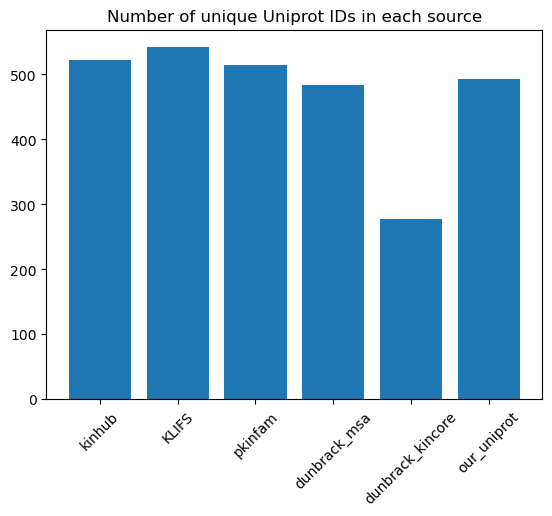

In [24]:
plt.bar(labels, y)
plt.xticks(rotation=45)
plt.title("Number of unique Uniprot IDs in each source");

Most datasets sit around the ~500 mark, with the exception of Dunbrack's Kincore, which has less since it only considers Uniprot IDs for which structural information is available.

As a result, we won't use Kincore for now since it's probably a subset of something else.

Let's continue by analyzing the overlaps.

### Dataset overlap

In [25]:
datasets = {
    "kinhub": kinhub,
    "klifs": klifs,
    "pkinfam": pkinfam,
    "reviewed_uniprot": reviewed_uniprot,
    "dunbrack_msa": dunbrack_msa,
}
uniprot_ids = {key: set(df.UniprotID.tolist()) for key, df in datasets.items()}

With the dictionary above (`name --> set of Uniprot IDs`), we can now analyze the overlap between sets:

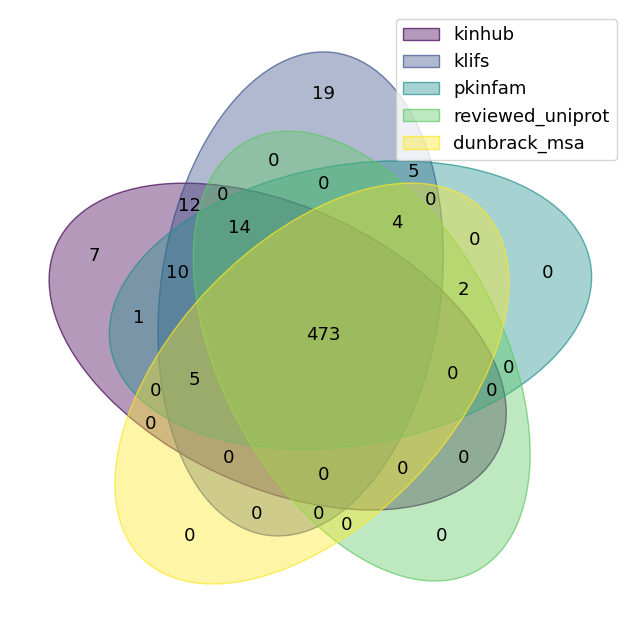

In [26]:
import venn
from venn import venn as plot_venn

v = plot_venn(uniprot_ids)
v;

In [27]:
def compute_petals(dict_of_datasets):
    """
    Function adapted from `venn._venn.generate_petal_labels`:
        https://github.com/LankyCyril/pyvenn/blob/master/venn/_venn.py#L56
    """
    from venn._venn import generate_logics

    labels = list(dict_of_datasets.keys())
    datasets = list(dict_of_datasets.values())
    n_sets = len(datasets)
    dataset_union = set.union(*datasets)
    universe_size = len(dataset_union)
    petal_labels = {}
    for logic in generate_logics(n_sets):
        included_sets = [datasets[i] for i in range(n_sets) if logic[i] == "1"]
        excluded_sets = [datasets[i] for i in range(n_sets) if logic[i] == "0"]
        involved_labels = tuple([label for label, i in zip(labels, list(logic)) if i == "1"])
        petal_labels[involved_labels] = (
            dataset_union & set.intersection(*included_sets)
        ) - set.union(set(), *excluded_sets)
    return petal_labels

In [28]:
petals = compute_petals(uniprot_ids)
for tag, values in sorted(petals.items(), key=lambda kv: len(kv[0]), reverse=True):
    if not values:
        continue
    print(f"{len(values):4d} unique Uniprot IDs in ({len(tag)}-way overlap) {', '.join(tag)}")

 473 unique Uniprot IDs in (5-way overlap) kinhub, klifs, pkinfam, reviewed_uniprot, dunbrack_msa
   4 unique Uniprot IDs in (4-way overlap) klifs, pkinfam, reviewed_uniprot, dunbrack_msa
   5 unique Uniprot IDs in (4-way overlap) kinhub, klifs, pkinfam, dunbrack_msa
  14 unique Uniprot IDs in (4-way overlap) kinhub, klifs, pkinfam, reviewed_uniprot
   2 unique Uniprot IDs in (3-way overlap) pkinfam, reviewed_uniprot, dunbrack_msa
  10 unique Uniprot IDs in (3-way overlap) kinhub, klifs, pkinfam
   5 unique Uniprot IDs in (2-way overlap) klifs, pkinfam
   1 unique Uniprot IDs in (2-way overlap) kinhub, pkinfam
  12 unique Uniprot IDs in (2-way overlap) kinhub, klifs
  19 unique Uniprot IDs in (1-way overlap) klifs
   7 unique Uniprot IDs in (1-way overlap) kinhub


We can observe several interesting points here:

* There's a set of 473 kinases on which all datasets agree.

#### Overlap for eukaryotic kinases only

It might be that the disagreements are reduced if we only consider eukaryotic kinases.

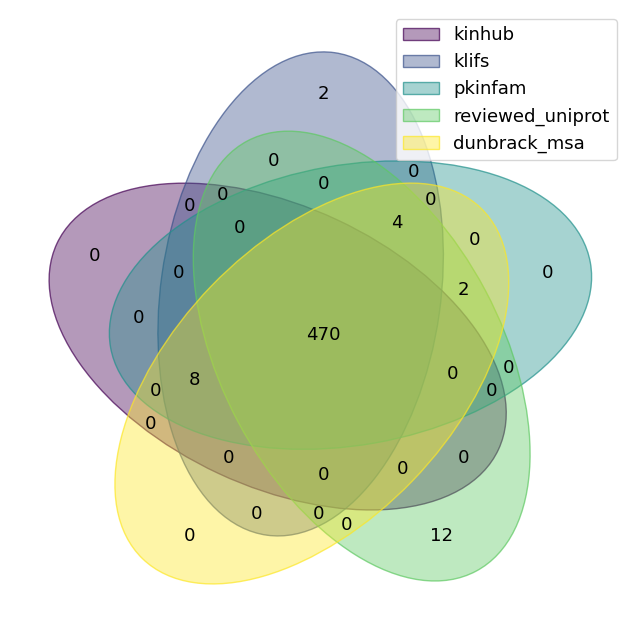

In [29]:
e_datasets = {
    "kinhub": kinhub[kinhub.Group != "Atypical"],
    "klifs": klifs[klifs.Group != "Atypical"],
    "pkinfam": pkinfam[~pkinfam.Family.str.contains("atypical", case=False)],
    "reviewed_uniprot": reviewed_uniprot[
        ~reviewed_uniprot["Protein names"].str.contains("atypical", case=False)
    ],
    "dunbrack_msa": dunbrack_msa[
        ~dunbrack_msa["14_Group_in_Manning"].str.contains("atypical", case=False)
    ],
}
e_uniprot_ids = {key: set(df.UniprotID.tolist()) for key, df in e_datasets.items()}
plot_venn(e_uniprot_ids);

In [30]:
epetals = compute_petals(e_uniprot_ids)
for tag, values in sorted(epetals.items(), key=lambda kv: len(kv[0]), reverse=True):
    if not values:
        continue
    print(f"{len(values):4d} unique Uniprot IDs in ({len(tag)}-way overlap) {', '.join(tag)}")

 470 unique Uniprot IDs in (5-way overlap) kinhub, klifs, pkinfam, reviewed_uniprot, dunbrack_msa
   4 unique Uniprot IDs in (4-way overlap) klifs, pkinfam, reviewed_uniprot, dunbrack_msa
   8 unique Uniprot IDs in (4-way overlap) kinhub, klifs, pkinfam, dunbrack_msa
   2 unique Uniprot IDs in (3-way overlap) pkinfam, reviewed_uniprot, dunbrack_msa
  12 unique Uniprot IDs in (1-way overlap) reviewed_uniprot
   2 unique Uniprot IDs in (1-way overlap) klifs


#### Overlap for atypical kinases only

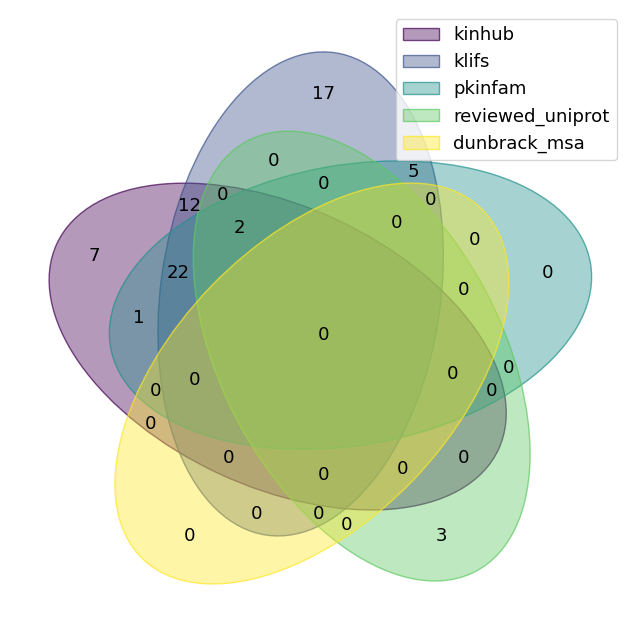

In [31]:
a_datasets = {
    "kinhub": kinhub[kinhub.Group == "Atypical"],
    "klifs": klifs[klifs.Group == "Atypical"],
    "pkinfam": pkinfam[pkinfam.Family.str.contains("atypical", case=False)],
    "reviewed_uniprot": reviewed_uniprot[
        reviewed_uniprot["Protein names"].str.contains("atypical", case=False)
    ],
    "dunbrack_msa": dunbrack_msa[
        dunbrack_msa["14_Group_in_Manning"].str.contains("atypical", case=False)
    ],
}
a_uniprot_ids = {key: set(df.UniprotID.tolist()) for key, df in a_datasets.items()}
plot_venn(a_uniprot_ids);

In [32]:
apetals = compute_petals(a_uniprot_ids)
for tag, values in sorted(apetals.items(), key=lambda kv: len(kv[0]), reverse=True):
    if not values:
        continue
    print(f"{len(values):4d} unique Uniprot IDs in ({len(tag)}-way overlap) {', '.join(tag)}")

   2 unique Uniprot IDs in (4-way overlap) kinhub, klifs, pkinfam, reviewed_uniprot
  22 unique Uniprot IDs in (3-way overlap) kinhub, klifs, pkinfam
   5 unique Uniprot IDs in (2-way overlap) klifs, pkinfam
   1 unique Uniprot IDs in (2-way overlap) kinhub, pkinfam
  12 unique Uniprot IDs in (2-way overlap) kinhub, klifs
   3 unique Uniprot IDs in (1-way overlap) reviewed_uniprot
  17 unique Uniprot IDs in (1-way overlap) klifs
   7 unique Uniprot IDs in (1-way overlap) kinhub


### Dissect the contents of each petal

Let's try to obtain information on the solitary leaves that include exclusive entries in each dataset. We can query the `petals` dictionary for information on the specific IDs. For example, which are those 3 unique IDs in KLIFS?

> Note: You need to query using _tuples_ of the dataset keys, even for single-set petals

In [33]:
print(*petals[("klifs",)])

Q9BTU6 Q8NEB9 Q9UJY1 P42356 Q9H6X2 Q9UBF8 Q8N8J0 O00750 P48426 O14986 O60331 O43921 P78356 P35557 Q8TBX8 O75747 A4QPH2 Q8TCG2 Q99755


Thanks to the Uniprot API we can check the GO annotations if we parse the lines starting with `DR   GO` that also contain `F:` (for function-related annotations):

In [34]:
def query_uniprot_for_go(*uniprot_ids):
    for i, entry in enumerate(uniprot_ids, 1):
        r = requests.get(rf"https://www.uniprot.org/uniprot/{entry}.txt")
        r.raise_for_status()
        print(i, entry)
        for line in r.text.splitlines():
            if line.startswith(("ID", "DE")):
                print(line)
            elif line.startswith("DR   GO;") and "; F:" in line:
                print(line)
        print()

In [35]:
query_uniprot_for_go(*petals[("klifs",)])

1 Q9BTU6
ID   P4K2A_HUMAN             Reviewed;         479 AA.
DE   RecName: Full=Phosphatidylinositol 4-kinase type 2-alpha;
DE            EC=2.7.1.67 {ECO:0000269|PubMed:11279162, ECO:0000269|PubMed:12324459, ECO:0000269|PubMed:20388919, ECO:0000269|PubMed:24675427, ECO:0000269|PubMed:25168678};
DE   AltName: Full=Phosphatidylinositol 4-kinase type II-alpha;
DR   GO; GO:0004430; F:1-phosphatidylinositol 4-kinase activity; IDA:UniProtKB.
DR   GO; GO:0035651; F:AP-3 adaptor complex binding; IDA:UniProtKB.
DR   GO; GO:0005524; F:ATP binding; IDA:UniProtKB.
DR   GO; GO:0000287; F:magnesium ion binding; NAS:UniProtKB.

2 Q8NEB9
ID   PK3C3_HUMAN             Reviewed;         887 AA.
DE   RecName: Full=Phosphatidylinositol 3-kinase catalytic subunit type 3;
DE            Short=PI3-kinase type 3;
DE            Short=PI3K type 3;
DE            Short=PtdIns-3-kinase type 3;
DE            EC=2.7.1.137 {ECO:0000269|PubMed:7628435};
DE   AltName: Full=Phosphatidylinositol 3-kinase p100 subunit;


#### Dissect eukariotic petals

In [36]:
print(*epetals[("klifs",)])

P35557 O43921


In [37]:
query_uniprot_for_go(*epetals[("klifs",)])

1 P35557
ID   HXK4_HUMAN              Reviewed;         465 AA.
DE   RecName: Full=Hexokinase-4 {ECO:0000305};
DE            Short=HK4 {ECO:0000305};
DE            EC=2.7.1.1 {ECO:0000269|PubMed:11916951, ECO:0000269|PubMed:15277402, ECO:0000269|PubMed:17082186, ECO:0000269|PubMed:18322640, ECO:0000269|PubMed:19146401, ECO:0000269|PubMed:25015100, ECO:0000269|PubMed:8325892};
DE   AltName: Full=Glucokinase {ECO:0000303|PubMed:1354840};
DE   AltName: Full=Hexokinase type IV {ECO:0000250|UniProtKB:P17712};
DE            Short=HK IV {ECO:0000250|UniProtKB:P17712};
DE   AltName: Full=Hexokinase-D {ECO:0000250|UniProtKB:P17712};
DR   GO; GO:0005524; F:ATP binding; IDA:UniProtKB.
DR   GO; GO:0008865; F:fructokinase activity; IBA:GO_Central.
DR   GO; GO:0004340; F:glucokinase activity; IDA:UniProtKB.
DR   GO; GO:0005536; F:glucose binding; IDA:UniProtKB.
DR   GO; GO:0019158; F:mannokinase activity; IBA:GO_Central.

2 O43921
ID   EFNA2_HUMAN             Reviewed;         213 AA.
DE   RecName: 

#### Dissect atypical petals

In [38]:
print(*apetals[("klifs",)])

Q9BTU6 P48426 P78356 Q9UBF8 Q99755 Q8NEB9 Q8N8J0 Q8TBX8 O14986 O75747 Q9UJY1 O60331 A4QPH2 P42356 Q8TCG2 O00750 Q9H6X2


In [39]:
query_uniprot_for_go(*apetals[("klifs",)])

1 Q9BTU6
ID   P4K2A_HUMAN             Reviewed;         479 AA.
DE   RecName: Full=Phosphatidylinositol 4-kinase type 2-alpha;
DE            EC=2.7.1.67 {ECO:0000269|PubMed:11279162, ECO:0000269|PubMed:12324459, ECO:0000269|PubMed:20388919, ECO:0000269|PubMed:24675427, ECO:0000269|PubMed:25168678};
DE   AltName: Full=Phosphatidylinositol 4-kinase type II-alpha;
DR   GO; GO:0004430; F:1-phosphatidylinositol 4-kinase activity; IDA:UniProtKB.
DR   GO; GO:0035651; F:AP-3 adaptor complex binding; IDA:UniProtKB.
DR   GO; GO:0005524; F:ATP binding; IDA:UniProtKB.
DR   GO; GO:0000287; F:magnesium ion binding; NAS:UniProtKB.

2 P48426
ID   PI42A_HUMAN             Reviewed;         406 AA.
DE   RecName: Full=Phosphatidylinositol 5-phosphate 4-kinase type-2 alpha {ECO:0000305};
DE            EC=2.7.1.149 {ECO:0000269|PubMed:9367159};
DE   AltName: Full=1-phosphatidylinositol 5-phosphate 4-kinase 2-alpha;
DE   AltName: Full=Diphosphoinositide kinase 2-alpha;
DE   AltName: Full=PIP5KIII;
DE   AltNa

### Interactive Venn diagrams

In [40]:
from ipywidgets import SelectMultiple, HBox, HTML, interact, fixed, Output


def interactive_venn(datasets, showkey=None):
    petals = {tuple(sorted(k)): v for (k, v) in compute_petals(datasets).items()}
    key = tuple(sorted(showkey))

    value = "Clickable UniprotIDs will appear here when you click on one more datasets"
    if showkey:
        uniprotids = list(petals[key])
        lines = [f"<b>{','.join(key)} ({len(uniprotids)})</b>:<br/>", "<ul>"]
        lines += [
            f"<li><a href='https://www.uniprot.org/uniprot/{i}' target='_blank'>{i}</a></li>"
            for i in uniprotids
        ]
        lines.append("</ul>")
        value = "".join(lines)
    text = HTML(
        value=value,
        placeholder="Clickable UniprotIDs will appear here when you click on one more datasets",
        disabled=True,
        layout={"height": "95%"},
    )

    out = Output()
    with out:
        plot = plot_venn(datasets)
        plt.show()

    display(HBox([out, text], layout={"height": "100%"}))

In [41]:
selection = SelectMultiple(
    options=list(uniprot_ids.keys()),
    value=[],
    description="Datasets",
)
interact(interactive_venn, datasets=fixed(uniprot_ids), showkey=selection);

interactive(children=(SelectMultiple(description='Datasets', options=('kinhub', 'klifs', 'pkinfam', 'reviewed_…

## Discussion

Looks like KLIFS is selecting some non-protein kinases like:

* phosphatidylinositol kinases
* saccharide kinases
* other proteins that bind ATP

> TODO: Why?

## Generate outputs

Since there'no agreement to what a kinase *is*, we will output everything already considered by the five listings we have analyzed.

Let's build the final dataframe with all kinases:

In [42]:
kinases = pd.concat(
    [
        kinhub[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(kinhub=1),
        klifs[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(klifs=1),
        pkinfam[["Name", "UniprotID"]].assign(pkinfam=1),
        reviewed_uniprot[["Entry Name", "UniprotID"]]
        .rename(columns={"Entry Name": "Name"})
        .assign(reviewed_uniprot=1),
        dunbrack_msa[["4_Uni_entry", "UniprotID"]]
        .rename(columns={"4_Uni_entry": "Name"})
        .assign(dunbrack_msa=1),
    ]
)
kinases

,Name,UniprotID,kinhub,klifs,pkinfam,reviewed_uniprot,dunbrack_msa
336,AAK1,Q2M2I8,1.0,NaN,NaN,NaN,NaN
0,ABL1,P00519,1.0,NaN,NaN,NaN,NaN
24,ABL2,P42684,1.0,NaN,NaN,NaN,NaN
529,ABR,Q12979,1.0,NaN,NaN,NaN,NaN
1,TNK2,Q07912,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
492,TYK2_HUMAN,P29597,NaN,NaN,NaN,NaN,1.0
493,TYK2_HUMAN,P29597,NaN,NaN,NaN,NaN,1.0
494,TYRO3_HUMAN,Q06418,NaN,NaN,NaN,NaN,1.0
495,YES_HUMAN,P07947,NaN,NaN,NaN,NaN,1.0


Since there are different names assigned to each Uniprot ID depending on the source, we will just concatenate them in the same column

In [43]:
keys = ["kinhub", "klifs", "pkinfam", "reviewed_uniprot", "dunbrack_msa"]
kinases["Name"] = kinases.transform({"Name": lambda v: v.replace("_HUMAN", "")})
boolsum = lambda v: v.sum() > 0
joinset = lambda v: "|".join([x for x in set(v) if x])
grouped = kinases.groupby(["UniprotID"], as_index=False).agg(
    dict(**{"Name": joinset}, **{k: boolsum for k in keys})
)
grouped

,UniprotID,Name,kinhub,klifs,pkinfam,reviewed_uniprot,dunbrack_msa
0,A0A0B4J2F2,SIK1B,False,False,True,True,True
1,A4QPH2,PI4KAP2,False,True,False,False,False
2,B5MCJ9,TRIM66,True,False,False,False,False
3,O00141,SGK1,True,True,True,True,True
4,O00238,BMPR1B|BMR1B,True,True,True,True,True
...,...,...,...,...,...,...,...
547,Q9Y616,IRAK3,True,True,True,True,True
548,Q9Y6E0,STK24,True,True,True,True,True
549,Q9Y6M4,KC1G3|CSNK1G3,True,True,True,True,True
550,Q9Y6R4,MAP3K4|M3K4,True,True,True,True,True


In [44]:
# example Uniprot ID with different names
grouped[grouped.UniprotID == "Q96LW2"]

,UniprotID,Name,kinhub,klifs,pkinfam,reviewed_uniprot,dunbrack_msa
433,Q96LW2,RSKR|SGK494|KS6R,True,True,True,True,True


We'll export the multi-kinase dataframe to a CSV in the repo:

In [45]:
grouped.to_csv(DATA / "human_kinases.aggregated.csv")